In [43]:
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


train_data = loadmat('train_32x32.mat')


# Print the keys of the loaded data
print("Keys in train_data:", train_data.keys())
print("Shape of X_train:", train_data['X'].shape)
print("Shape of y_train:", train_data['y'].shape)
# Print the first five samples
for i in range(1):
    print(f"Sample {i + 1} - Shape: {X_train[:, :, :, i].shape}")
    print(X_train[:, :, :, i])
    print("Label:", y_train[i])
    print("\n")

Keys in train_data: dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
Shape of X_train: (32, 32, 3, 73257)
Shape of y_train: (73257, 1)
Sample 1 - Shape: (32, 32, 3)
[[[154 156 155]
  [156 159 159]
  [157 161 162]
  ...
  [103 107 120]
  [ 99 100 117]
  [109 106 128]]

 [[162 164 163]
  [162 165 165]
  [159 163 165]
  ...
  [ 88  89 106]
  [ 90  91 111]
  [106 106 127]]

 [[169 171 170]
  [168 171 171]
  [162 165 167]
  ...
  [ 71  72  91]
  [ 81  82 103]
  [105 106 127]]

 ...

 [[159 155 156]
  [162 157 160]
  [164 159 163]
  ...
  [173 174 180]
  [167 170 176]
  [163 167 173]]

 [[161 156 158]
  [165 160 164]
  [168 163 168]
  ...
  [168 167 172]
  [162 162 167]
  [158 159 164]]

 [[163 158 161]
  [168 162 167]
  [171 167 173]
  ...
  [165 162 167]
  [157 155 160]
  [154 152 157]]]
Label: [1]




In [44]:
# Check for null values in each element
for key, value in train_data.items():
    if isinstance(value, np.ndarray) and value.size == 0:
        print(f"Null values in {key}")
    else: print(f"NO NULL in {key}")

NO NULL in __header__
NO NULL in __version__
NO NULL in __globals__
NO NULL in X
NO NULL in y


In [45]:
# Check the data types of each element
for key, value in train_data.items():
    print(f"Data type of {key}: {type(value)}")

Data type of __header__: <class 'bytes'>
Data type of __version__: <class 'str'>
Data type of __globals__: <class 'list'>
Data type of X: <class 'numpy.ndarray'>
Data type of y: <class 'numpy.ndarray'>


In [55]:
#data Extration (features)
X_train = train_data['X']
y_train = train_data['y']
classes = len(np.unique(y_train))
# print(classes)

# Create an empty list to store indices for each class
subset_classes = []

# Iterate over each class
for class_label in range(classes):
    # print(class_label)
    # Find indices of samples belonging to the current class
    indices_for_class = np.where(y_train == class_label+1)[0]
    
    # Check if there are enough samples for the current class
    if len(indices_for_class) >= 2500:
        # Randomly select 2500 samples if available
        selected_indices = np.random.choice(indices_for_class, size=2500, replace=False)
        subset_classes.extend(selected_indices)
    else:
        # If there are not enough samples, use all available samples for this class
        subset_classes.extend(indices_for_class)

# Convert the list to a NumPy array
subset_classes = np.array(subset_classes)
print(subset_classes)

# New dataset of size 2500
subset_classes_X_train = X_train[:, :, :, subset_classes ]
subset_classes_Y_train = y_train[subset_classes ]

# dataset verification
print("Shape of X_train_subset:", subset_classes_X_train.shape)
print("Shape of y_train_subset:", subset_classes_Y_train.shape)

[  721 19270 30242 ... 58901 34761 28188]
Shape of X_train_subset: (32, 32, 3, 25000)
Shape of y_train_subset: (25000, 1)


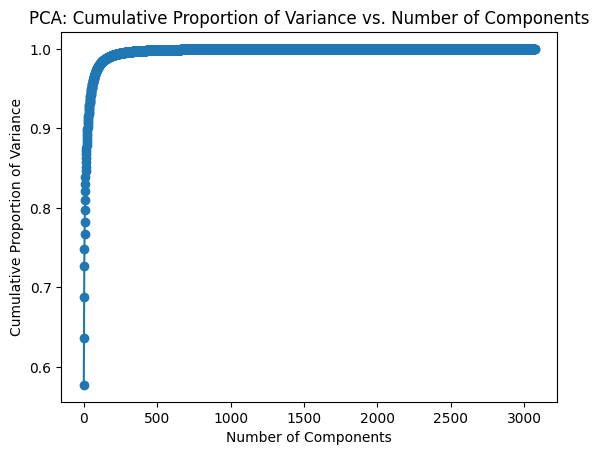

Number of components to keep 90% variance: 27


In [59]:
# Flatten the data for PCA
X_train_2D = subset_classes_X_train.reshape((32*32*3,-1))

# Standardize the data
scaler = StandardScaler()
X_train_standardized = X_train_2D.T

# Perform PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_standardized)

# Cumulative sum of explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to keep for 90% variance
num_components_90 = np.argmax(cumulative_variance > 0.9) + 1

# Plot PoV against the number of components
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Proportion of Variance')
plt.title('PCA: Cumulative Proportion of Variance vs. Number of Components')
plt.show()

print(f"Number of components to keep 90% variance: {num_components_90}")

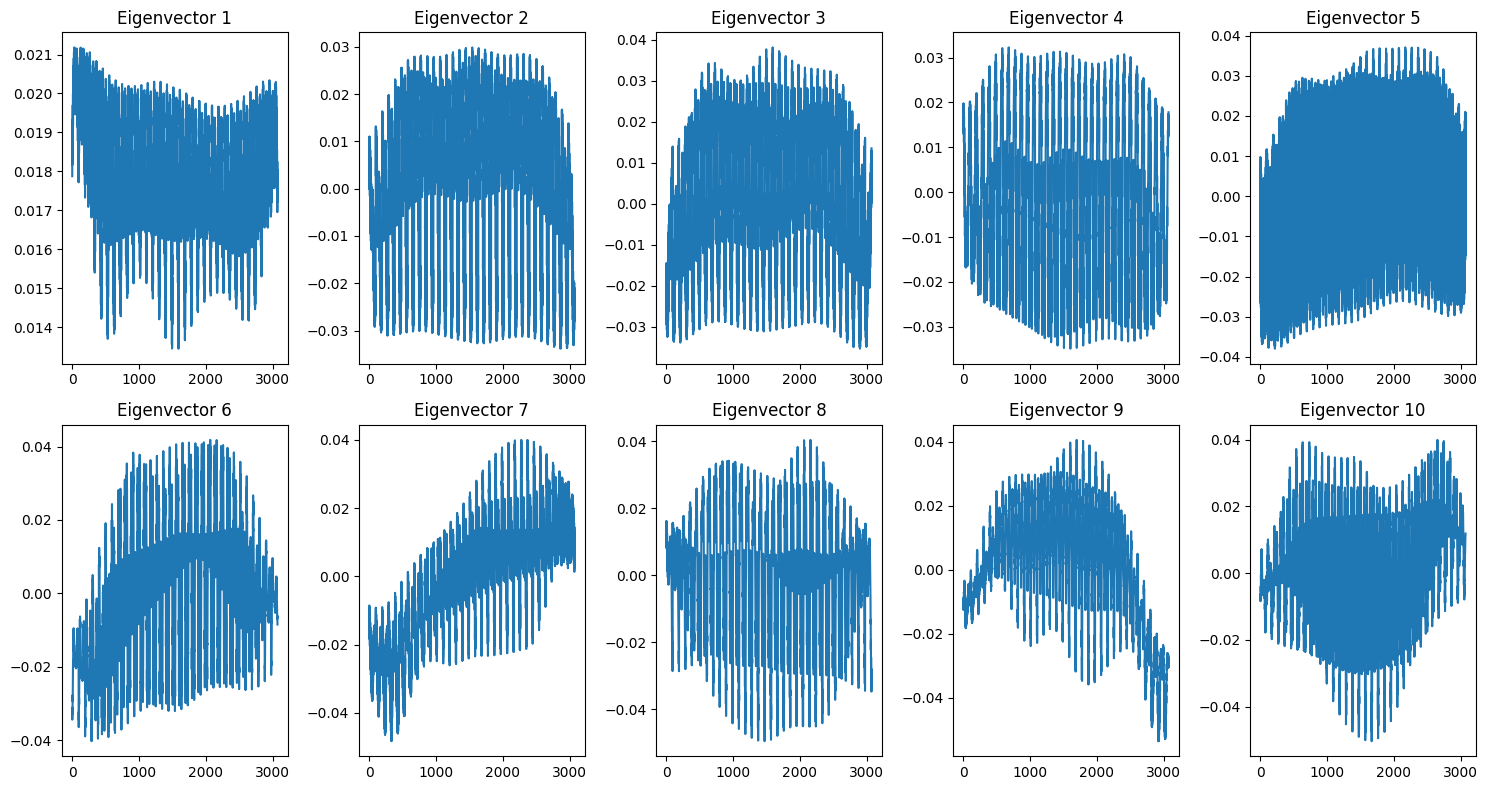

In [60]:
# Assuming top_10_eigenvectors is a 2D array where each row is an eigenvector
top_10_eigenvectors = pca.components_[:10, :]

# Plotting the values along each dimension for the top 10 eigenvectors
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.plot(top_10_eigenvectors[i])
    plt.title(f'Eigenvector {i + 1}')

plt.tight_layout()
plt.show()

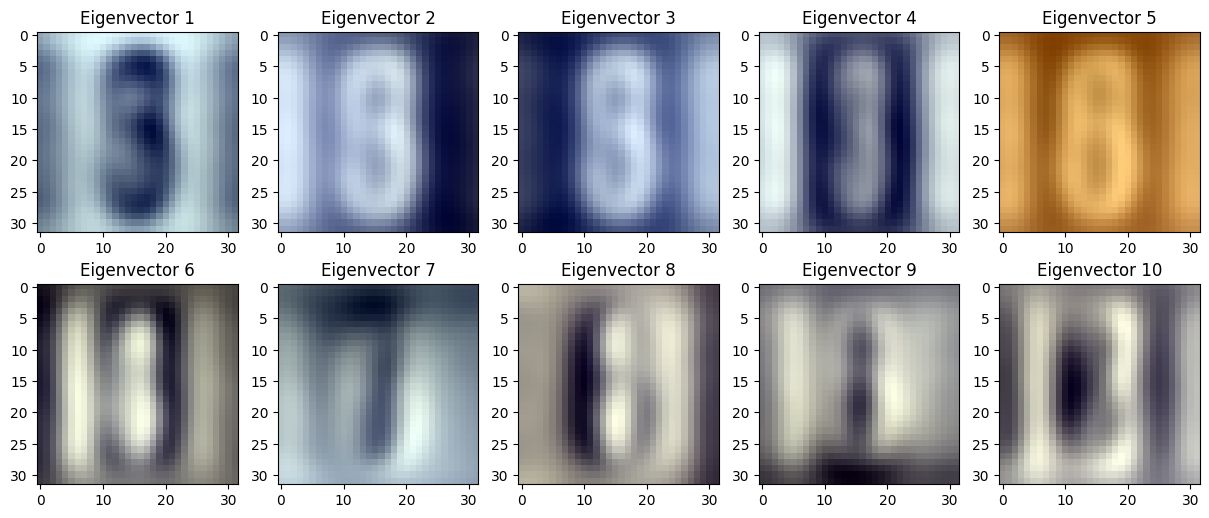

In [63]:


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Reshape eigenvector to image shape
    reshaped_eigenvector = top_10_eigenvectors[i].reshape((32, 32, 3))

    # Convert values to [0, 255] range
    normalized_eigenvector = ((reshaped_eigenvector - reshaped_eigenvector.min()) / 
                              (reshaped_eigenvector.max() - reshaped_eigenvector.min()) * 255)

    # Display the eigenvector as an image
    ax.imshow(normalized_eigenvector.astype(np.uint8), cmap='magma')

    ax.set_title(f'Eigenvector {i + 1}')

plt.show()


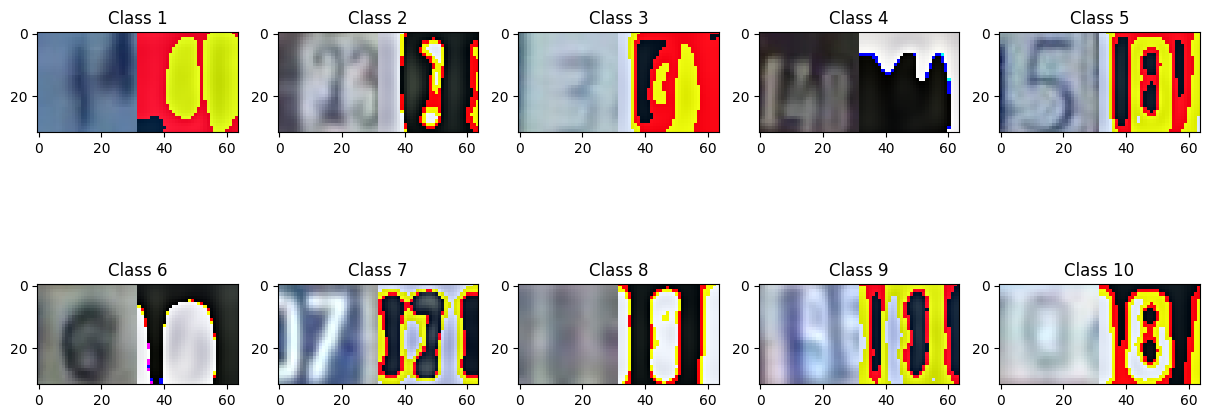

In [107]:
# Use the top 10 eigenvectors for reconstruction
top_10_eigenvectors = pca.components_[:10, :]

# Reconstruct 10 samples (one from each class) using the top 10 eigenvectors
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    # Select one sample from each class
    class_indices = np.where(subset_classes_Y_train == i + 1)[0]
    sample_index = np.random.choice(class_indices, size=1)[0]
    
    # Get the original image
    original_image = subset_classes_X_train[:, :, :, sample_index]
    
    # Flatten the original image for reconstruction
    original_flattened = original_image.reshape((32*32*3, -1)).T
    
    # Project the flattened image onto the top 10 eigenvectors
    projected_image = np.dot(original_flattened, top_10_eigenvectors.T)
    
    # Reconstruct the image using the top 10 eigenvectors
    reconstructed_image = np.dot(projected_image, top_10_eigenvectors) + pca.mean_
    
    # Reshape the reconstructed image to its original shape
    reconstructed_image = reconstructed_image.reshape((32, 32, 3))
    
    # Display the original and reconstructed images side by side
    ax.imshow(np.hstack([original_image.astype(np.uint8), reconstructed_image.astype(np.uint8)]))
    ax.set_title(f"Class {i + 1}")

plt.show()


In [53]:
print("Shape of X_train_pca[:, :10]:", X_train_pca[:, :10].shape)
print("Shape of y_train:", y_train.shape)


Shape of X_train_pca[:, :10]: (25000, 10)
Shape of y_train: (25000, 1)


In [109]:
def run_knn(X_train, y_train, X_test, y_test, k):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train, y_train)
    y_pred = knn_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Function to run k-NN on raw data
def run_knn_raw_data(X_train, y_train, X_test, y_test, k):
    X_train_flat = X_train.reshape((32*32*3, -1)).T
    X_test_flat = X_test.reshape((32*32*3, -1)).T
    return run_knn(X_train_flat, y_train, X_test_flat, y_test, k)

# Function to run k-NN on PCA-reduced data
def run_knn_pca(X_train, y_train, X_test, y_test, k, num_components):
    X_train_pca_subset = X_train[:, :num_components]
    X_test_pca_subset = X_test[:, :num_components]
    return run_knn(X_train_pca_subset, y_train, X_test_pca_subset, y_test, k)

# Run k-NN on raw data
knn_accuracy_raw_data = run_knn_raw_data(X_train, y_train.ravel(), X_test, y_test.ravel(), k=7)
print(f"Accuracy of k-NN on raw data: {knn_accuracy_raw_data:.4f}")

# Run k-NN on PCA-reduced data with dimensions as in part (a)
knn_accuracy_pca_a = run_knn_pca(X_train_standardized, y_train.ravel(), X_test_pca, y_test.ravel(), k=7, num_components=num_components_90)
print(f"Accuracy of k-NN on PCA (part a): {knn_accuracy_pca_a:.4f}")

# Run k-NN on PCA-reduced data with 10 components as in part (b)
knn_accuracy_pca_b = run_knn_pca(X_train_standardized, y_train.ravel(), X_test_standardized, y_test.ravel(), k=7, num_components=10)
print(f"Accuracy of k-NN on PCA (part b): {knn_accuracy_pca_b:.4f}")

Accuracy of k-NN on raw data: 0.4751


ValueError: Found input variables with inconsistent numbers of samples: [25000, 73257]